# Assignment 7.2

Using the GP software, reproduce the second example of lesson 7.3. The code to produce the data is the following. To produce different data, change the seed number.

#### Importing Packages

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

##### Defining functions

In [126]:
def buffer(x, n, p=0):
    # From https://stackoverflow.com/questions/38453249/is-there-a-matlabs-buffer-equivalent-in-numpy
    i = 0
    result = x[:n]
    i = n
    result = list(np.expand_dims(result, axis=0))
    while i < len(x):
        col = x[i:i+(n-p)]
        if p != 0:
            col = np.hstack([result[-1][-p:], col])
        if len(col):
            col = np.hstack([col, np.zeros(n - len(col))])
        result.append(np.array(col))
        i += (n - p)
    return np.vstack(result).T

def data(N, m, sigma, seed=100):
    # From Marc Bernard
    # m: predictor input length (the slides use '3')
    # N: shape Number of samples (the slides use 100)
    # sigma: Noise standard deviation
    m = m+1    
    np.random.seed(seed)
    x = np.random.randn(1, N)
    b, a = signal.butter(4, 0.05)
    f = signal.filtfilt(b, a, x)
    temp = f + sigma*np.random.randn(1, N)
    temp = buffer(temp, m, m-1)
    y = temp[-1,:].T
    Y = temp[0:-2,:]
    return Y, y

def sliding_window(x, w = 1, d = 0):
    N = len(x)
    m = int(np.ceil((N-w)/(w-d)) + 1)
    X = np.zeros([w,m])
    for i,j in zip(range(0,N,w-d),range(0,m)):
        X[:,j] = x[i:i + w]
    return X

##### Defining Experiment Parameters

In [127]:
Total_Samples = 500
B = 4
sigma = 0.1
N_train =int(Total_Samples*0.5)
# SeedNum = np.random.randint(1000)
W = 10
M = 10
delta_t = 0.1

print("The sliding window time is "+str(delta_t*W)+" seconds, and it contains "+ str(delta_t*W/2/np.pi)+" periods.")
print("The prediction horizon is "+str(delta_t*M)+" seconds.")

The sliding window time is 1.0 seconds, and it contains 0.15915494309189535 periods.
The prediction horizon is 1.0 seconds.


##### Generating Data

In [128]:
y_base,y = data(Total_Samples,B,sigma,SeedNum)
y_base = y_base.ravel()
x = np.linspace(0,Total_Samples-2,Total_Samples-2)
x = x.ravel()

print(f"The shape of y_base is {y_base.shape}")
print(f"The shape of x is {x.shape}")

The shape of y_base is (498,)
The shape of x is (498,)


##### Plotting the data

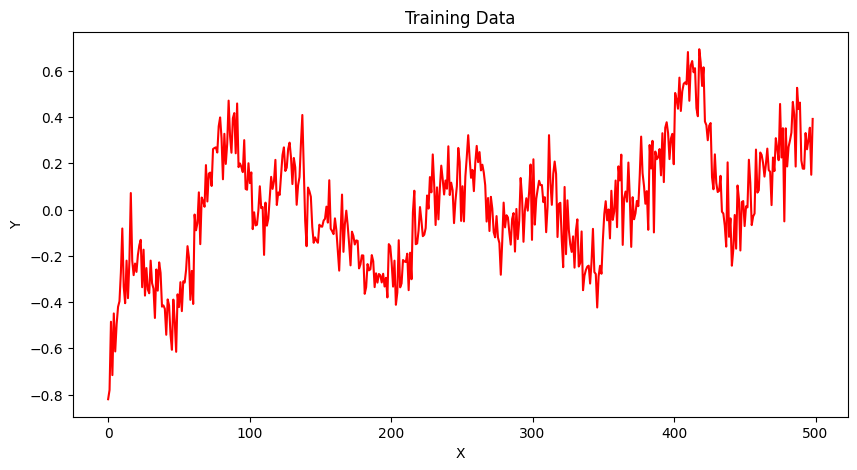

In [129]:
plt.figure(figsize=(10,5))
plt.plot(x,y_base,color='red',label='x')
plt.title('Training Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

##### Segregating test and training data

In [130]:
# Splitting the data into training and testing using n_train
y_train = y_base[:N_train]
x_train_all = x[M+W-1:N_train]
y_test = y_base[N_train:]
x_test_all = x[N_train+M+W-1:]

# data transformed from the sliding window
x_train = sliding_window(y_train[:-M],W,W-1).T
y_train = y_train[M+W-1:]

x_test = sliding_window(y_test[:-M],W,W-1).T
y_test = y_test[M+W-1:]
delta_t*W
print(f"The shape of x_train is {x_train.shape}")
print(f"The shape of y_train is {y_train.shape}")
print(f"The shape of x_test is {x_test.shape}")
print(f"The shape of y_test is {y_test.shape}")
print(f"The shape of x_train_all is {x_train_all.shape}")
print(f"The shape of x_test_all is {x_test_all.shape}")


The shape of x_train is (231, 10)
The shape of y_train is (231,)
The shape of x_test is (229, 10)
The shape of y_test is (229,)
The shape of x_train_all is (231,)
The shape of x_test_all is (229,)


##### Running the GP software

In [131]:
kernel = 1 * DotProduct() + WhiteKernel()

gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(x_train, y_train)
gaussian_process.kernel_
mean_prediction, std_prediction = gaussian_process.predict(x_test, return_std=True)

print(f"GP score on training data:  {gaussian_process.score(x_train, y_train):.2f}")
print(f"GP score on test data:      {gaussian_process.score(x_test, y_test):.2f}")
print(f"GP kernel:                  {gaussian_process.kernel_}")

GP score on training data:  0.55
GP score on test data:      0.42
GP kernel:                  0.226**2 * DotProduct(sigma_0=0.0539) + WhiteKernel(noise_level=0.0241)


##### Plotting the Results

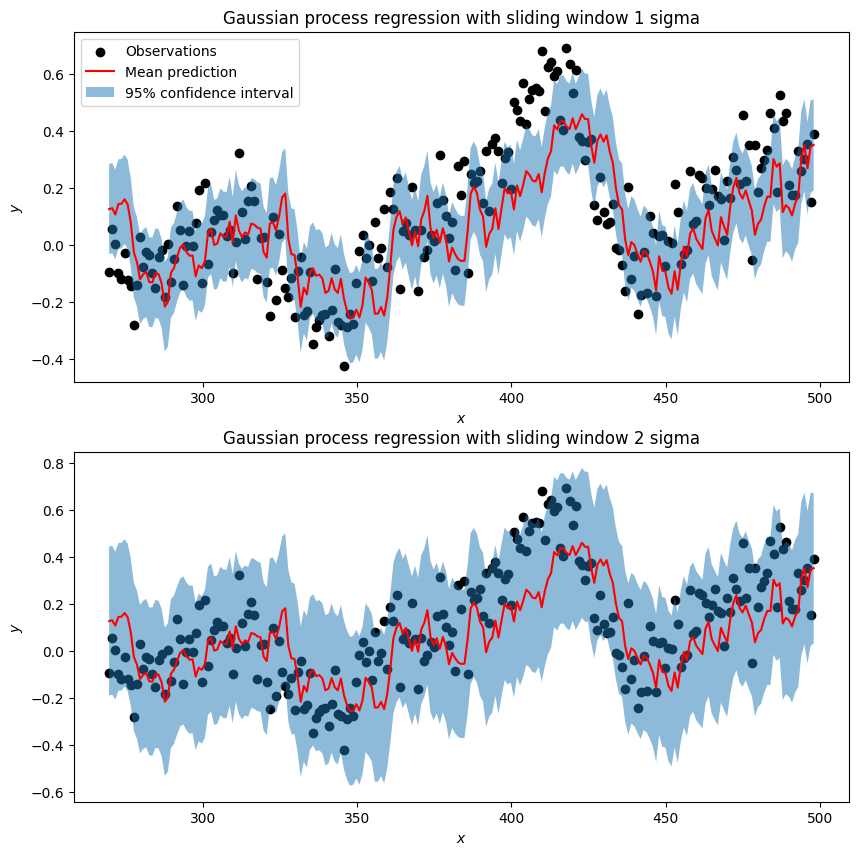

In [132]:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.scatter(x_test_all,y_test,color='black', label="Observations")
plt.plot(x_test_all, mean_prediction, label="Mean prediction",color="red")
plt.fill_between(
    x_test_all.ravel(),
    mean_prediction - 1 * std_prediction,
    mean_prediction + 1 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Gaussian process regression with sliding window 1 sigma")
plt.legend(loc="best")

plt.subplot(2,1,2)
plt.scatter(x_test_all,y_test,color='black', label="Observations")
plt.plot(x_test_all, mean_prediction, label="Mean prediction",color="red")
plt.fill_between(
    x_test_all.ravel(),
    mean_prediction - 2 * std_prediction,
    mean_prediction + 2 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Gaussian process regression with sliding window 2 sigma")

plt.show()